## 14. SVM


### import

In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

for i in [np, pd, mpl, sns, sklearn]:
    print(i.__name__, i.__version__)

numpy 1.18.5
pandas 0.25.1
matplotlib 3.5.3
seaborn 0.12.2
sklearn 0.21.3


### 예제 데이터셋 준비

In [2]:
df_gene = pd.read_csv('data/gene.csv', index_col='patient')
df_gene.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer,train
patient,,,,,,,,,,,,,,,,,,,,,
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,ALL,True
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,ALL,True
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,ALL,True
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,ALL,True
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,ALL,True


### 1.선형 마진 분류기(Linear Discriminant)

- 선형 함수를 이용한 클래스 분류 모델

$f(\mathbf{x}_i) = \mathbf{w}^T\mathbf{x}_i + b$ $\mathbf{w} = \begin{bmatrix} w_1 \\ w_2 \\ ... \\ w_k \end{bmatrix}$ $\mathbf{x}_i = \begin{bmatrix} x_{i1} \\ x_{i2} \\ ... \\ x_{ik} \end{bmatrix}$ $b$:상수

$\hat{y}_i = sign(y_i) = \begin{cases} if\ f(\mathbf{x}_i) \geq 0, 1 \\ if\ f(\mathbf{x}_i) < 0, -1 \end{cases}$ $\hat{y}_i \in \{-1, 1\}$

In [3]:
df_toy = pd.DataFrame({
    'x1': [1.5, 2.5, 2, 3, 1, 4, 2, 3, 3.4, 2.5],
    'x2': [2, 4.2, 2, 4, 1, 2, 0, 0.8, 0.5, 1],
    'Class': [1, 1, 1, 1, 1, -1, -1, -1, -1, -1]
})

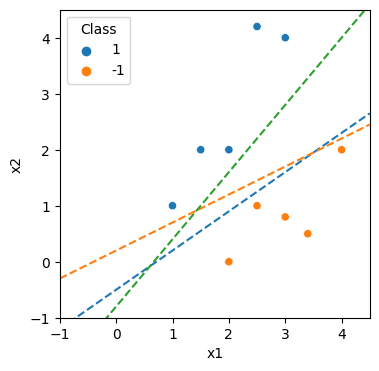

In [4]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
plt.gca().set_xlim(-1, 4.5)
plt.gca().set_ylim(-1, 4.5)
x1_range = np.array([-1, 4.5])
for i in [[0.7, -0.5], [0.5, 0.2], [1.2, -0.8]]:
    plt.plot(x1_range, i[0] * x1_range + i[1], linestyle='dashed')

plt.show()

- 학습: 최대 마진 분류

> 모든 i에 대해,
>
> $\hat{y}_i = sign(y_i) = \begin{cases} if\ f(\mathbf{x}_i) \geq 0, 1 \\ if\ f(\mathbf{x}_i) < 0, -1 \end{cases}$ $\hat{y}_i \in \{-1, 1\}$
> 
> 기하학적 마진을 최대화하는 $\mathbf{w}, b$를 찾는 것


### 2. 최대 마진 분류

#### 기하학적 마진

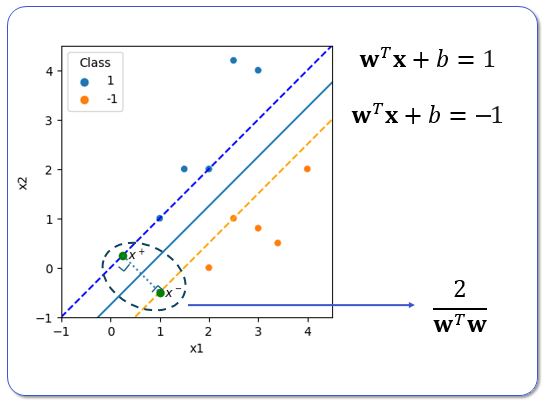

- 유도과정

> $\lambda$:기하학적마진
>
> $\begin{cases} \mathbf{w}^T\mathbf{x}^+ + b = 1 \\ \mathbf{w}^T\mathbf{x}^- + b = -1 \end{cases}$
>
> $\mathbf{w}$는 두 평면에 수직인 벡터에서,
> $\mathbf{x}^+, \mathbf{x}^-$는 아래와 같은 관계를 지님
>
> $\mathbf{x}^+ = \mathbf{x}^- + \lambda\mathbf{w}$
>
> $\begin{cases} \mathbf{w}^T(\mathbf{x}^- + \lambda\mathbf{w}) + b = 1 \\ \mathbf{w}^T\mathbf{x}^- + b = -1 \end{cases}$
>
> $\begin{cases} \mathbf{w}^T x^- + \lambda\mathbf{w}^T\mathbf{w} + b = 1 \\ \mathbf{w}^T\mathbf{x}^- + b = -1 \end{cases}$ $\Rightarrow$ $\lambda = \frac{2}{\mathbf{w}^T\mathbf{w}}$


#### 선형 분류기 학습: 최대 마진 분류

모든 $i$에 대해,

$if\ y_i = 1, \mathbf{w}^T\mathbf{x}_i + b \geq 1$

$if\ y_i = -1, \mathbf{w}^T\mathbf{x}_i + b < -1$

$\Rightarrow$ $y_i(\mathbf{w}^T\mathbf{x}_i + b) - 1 \geq 0$

기하학적마진을 최대화하는 $\mathbf{w}, b$를 찾는 것

$\Rightarrow$ $\frac{2}{\mathbf{w}^T\mathbf{w}}$를 최대화하는 $\mathbf{w}, b$를 찾는 것 $\Rightarrow$ $\frac{1}{2}\mathbf{w}^T\mathbf{w}$를 최소화하는 $\mathbf{w}, b$를 찾는 것

**[Ex.1]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

기하학적 마진을 구하는 공식을 이용하여 두 결정 경계에 있는 임의의 점 $x^+, x^-$을 도식화 해봅니다.

```
w, b = np.array([-1.3333, 1.3333]), -0.75
```

입니다.
    
</div>

In [5]:
w, b = np.array([-1.3333, 1.3333]), -0.75
x_minus = np.array([1, -0.5])
lam = 2 / np.dot(w.T, w) # (2)번 식에서 도출
x_plus = x_minus + lam * w
x_minus, x_plus, lam

(array([ 1. , -0.5]), array([0.24998125, 0.25001875]), 0.5625281260547227)

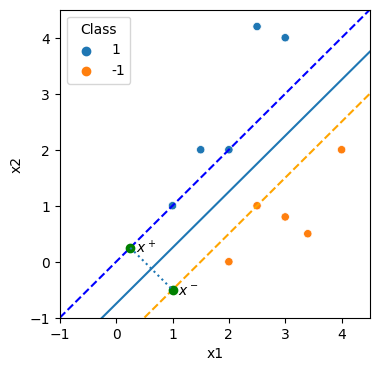

In [6]:
plt.figure(figsize=(4, 4))
plt.gca().set_xlim(-1, 4.5)
plt.gca().set_ylim(-1, 4.5)
sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
x1_range = np.array([-1, 4.5])

plt.plot(x1_range, 1 * x1_range - 0.75)
plt.plot(x1_range, 1 * x1_range - 0.75 + 0.75, linestyle='dashed', color='blue')
plt.plot(x1_range, 1 * x1_range - 0.75 - 0.75, linestyle='dashed', color='orange')
plt.plot(*x_minus, 'go')
plt.text(*(x_minus + np.array([0.1, -0.1])), '$x^-$')
plt.plot(*x_plus, 'go')
plt.text(*(x_plus + np.array([0.1, -0.1])), '$x^+$')
plt.gca().add_line(mlines.Line2D([x_plus[0], x_minus[0]], [x_plus[1], x_minus[1]], linestyle='dotted'))

plt.show()

#### 선형 분류기 학습법: 최대 마진 분류

- 모든 $i$에 대해 $y_i(\mathbf{w}^T\mathbf{x}_i + b) \geq 1$일 때,

$\Rightarrow$ $\frac{1}{2}\mathbf{w}^T\mathbf{w}$를 최소화하는 $\mathbf{w}, b$를 찾는 것

- 제약이 있는 최적화 문제의 해를 찾는 방법 $\Rightarrow$ 라그랑지안(Lagrangian) 승수법

#### 라그랑지안(Lagrangian) 승수법

$h_i(\boldsymbol{\theta}) = 0$일 때, $(i = 1, ... m)$ $\underset{\boldsymbol{\theta}}{minimize}\ f(\boldsymbol{\theta})$

$L(\boldsymbol{\theta}, \boldsymbol{\mu}) = f(\boldsymbol{\theta}) + \langle \boldsymbol{\mu}, h(\boldsymbol{\theta}) \rangle$

$\boldsymbol{\theta} = \begin{bmatrix} \theta_1 \\ \theta_2 \\ ... \\ \theta_n \end{bmatrix}$ $\boldsymbol{\mu} = \begin{bmatrix} \mu_1 \\ \mu_2 \\ ... \\ \mu_m \end{bmatrix}$ 라그랑지안 승수 $h(\boldsymbol{\theta}) = \begin{bmatrix} h_1(\boldsymbol{\theta}) \\ h_2(\boldsymbol{\theta}) \\ ... \\ h_m(\boldsymbol{\theta}) \end{bmatrix}$

최적점의(필요)조건

$\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}^*) + \nabla_{\boldsymbol{\theta}} \langle \boldsymbol{\mu}, h(\boldsymbol{\theta}^*) \rangle = \mathbf{0}$ 정상조건(Stationarity)

$h(\boldsymbol{\theta}^*) = \mathbf{0}$ 원조건(Primal feasibility)


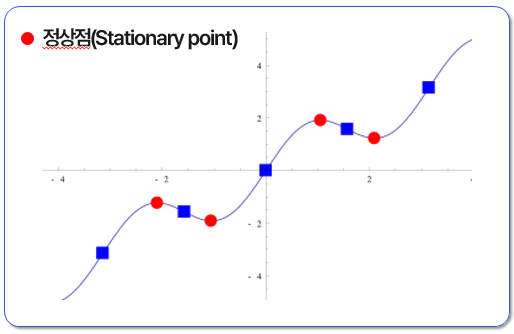

#### KKT(Karush-Kuhn-Turker) 조건
- 최대 마진 분류에서의 조건: $y_i(\mathbf{w}^T\mathbf{x}_i + b) - 1 \geq 0$
- 
▷ 조건이 등호만으로 구성된 라그랑지안 승수법에 그대로 적용 불가능

- KKT(Karush-Kuhn-Turker) 조건 적용
- 충족을 한다면, 라그랑지안 승수법에 부등호 까지 적용할 수 있음

$g_i(\boldsymbol{\theta}) \leq 0$일 때, $(i = 1, ... m)$

$h_i(\boldsymbol{\theta}) = 0$일 때, $(i = 1, ... n)$ 

$\Rightarrow$ $\underset{\boldsymbol{\theta}}{minimize}\ f(\boldsymbol{\theta})$

$L(\boldsymbol{\theta}, \boldsymbol{\lambda}, \boldsymbol{\mu}) = f(\mathbf{x}) + \langle \boldsymbol{\lambda}, g(\boldsymbol{\theta}) \rangle + \langle \boldsymbol{\mu}, h(\boldsymbol{\theta}) \rangle$

$\boldsymbol{\theta} = \begin{bmatrix} \theta_1 \\ \theta_2 \\ ... \\ \theta_n \end{bmatrix}$ $\boldsymbol{\lambda} = \begin{bmatrix} \lambda_1 \\ \lambda_2 \\ ... \\ \lambda_m \end{bmatrix}$ $g(\boldsymbol{\theta}) = \begin{bmatrix} g_1(\boldsymbol{\theta}) \\ g_2(\boldsymbol{\theta}) \\ ... \\ g_m(\boldsymbol{\theta}) \end{bmatrix}$ $\boldsymbol{\mu} = \begin{bmatrix} \mu_1 \\ \mu_2 \\ ... \\ \mu_k \end{bmatrix}$ $h(\boldsymbol{\theta}) = \begin{bmatrix} h_1(\boldsymbol{\theta}) \\ h_2(\boldsymbol{\theta}) \\ ... \\ h_k(\boldsymbol{\theta}) \end{bmatrix}$

- 라그랑지안(Lagrangian) 승수법+KKT 조건

정상조건(Stationarity): $\nabla_{\mathbf{x}} f(\mathbf{x}^*) + \nabla_{\mathbf{x}} \langle \boldsymbol{\lambda}, g(\mathbf{x}^*) \rangle + \nabla_{\mathbf{x}} \langle \boldsymbol{\mu}, h(\mathbf{x}^*) \rangle = \mathbf{0}$ 
 
원조건(Primal feasibility): $g(\mathbf{x}^*) \leq \mathbf{0}$ $h(\mathbf{x}^*) = \mathbf{0}$ 

쌍대 조건(Dual feasibility): $\boldsymbol{\lambda} \geq \mathbf{0}$

여부등조건(Complementary slackness): $\boldsymbol{\lambda} \circ \mathbf{g}(\mathbf{x}^*) = 0$ 

#### 라그랑지안(Lagrangian) 승수법+KKT 조건 적용

$g_i(\mathbf{w}, b) \leq 0$일 때, $(i = 1, ... m)$

$\Rightarrow$ $\underset{\mathbf{w}, b}{minimize} \frac{1}{2} \mathbf{w}^T \mathbf{w}$ 

$\mathbf{w} = \begin{bmatrix} w_1 \\ w_2 \\ ... \\ w_n \end{bmatrix}$ $\boldsymbol{\alpha} = \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ ... \\ \alpha_m \end{bmatrix}$ $g(\mathbf{w}, b) = \begin{bmatrix} -y_1(\mathbf{w}^T\mathbf{x}_1 + b) + 1 \\ -y_2(\mathbf{w}^T\mathbf{x}_2 + b) + 1 \\ ... \\ -y_m(\mathbf{w}^T\mathbf{x}_m + b) + 1 \end{bmatrix}$ $\mathbf{x}_i = \begin{bmatrix} x_{i1} \\ x_{i2} \\ ... \\ x_{in} \end{bmatrix}$

$L(\mathbf{w}, b, \boldsymbol{\alpha}) = f(\mathbf{x}) + \langle \boldsymbol{\alpha}, g(\mathbf{w}, b) \rangle$

정상조건(Stationarity)

> $\nabla_{\mathbf{w}} \frac{1}{2} \mathbf{w}^{*T} \mathbf{w}^* + \nabla_{\mathbf{w}} \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b) \rangle = \mathbf{0}$ $\Rightarrow$ $\mathbf{w}^* - X^T(\boldsymbol{\alpha} \circ \mathbf{y}) = \mathbf{0}$ $\Rightarrow$ $\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$
>
> $\frac{d \frac{1}{2} \mathbf{w}^{*T} \mathbf{w}^*}{db} + \frac{d \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b) \rangle}{db} = 0$ $\Rightarrow$ $\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$

원조건(Primal feasibility): $g(\mathbf{w}^*, b^*) \leq \mathbf{0}$ 

쌍대 조건(Dual feasibility): $\boldsymbol{\alpha} \geq \mathbf{0}$ 

여부등조건(Complementary slackness): $\boldsymbol{\alpha} \circ \mathbf{g}(\mathbf{w}^*, b^*) = 0$ 

- 위 5가지이 $w^*, b^*$의 닫힌 해(Closed form solution)를 찾을 수 없음

▷ 쌍대 문제(Dual Problem)으로 전환하여, 목적 함수를 도출하여 최적화 알고리즘 적용

#### 쌍대 문제(Dual Problem)

원문제(Primal Problem) $\Rightarrow$ 쌍대문제(Dual Problem)

$\underset{\mathbf{w}, b}{minimize}\ f(\mathbf{w}, b)$ $\Rightarrow$ $\underset{\boldsymbol{\alpha}}{maximize}\ L_D(\boldsymbol{\alpha})$

$L_D(\boldsymbol{\alpha})$의유도

정상조건(Stationarity)에서유도된

$\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$,
$\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$ 을

$L(\mathbf{w}, b, \boldsymbol{\alpha})$에 대입

$L(\mathbf{w}, b, \boldsymbol{\alpha}) = \frac{1}{2} \mathbf{w}^T \mathbf{w} + \langle \boldsymbol{\alpha}, g(\mathbf{w}, b) \rangle$

$L_D(\boldsymbol{\alpha}) = \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y}) - (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y}) + \sum_{i=1}^{m} \alpha_i$

#### 쌍대 문제 전환 정리

$\underset{\boldsymbol{\alpha}}{maximize} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y})$

$\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$ $g(\mathbf{w}^*, b^*) \leq \mathbf{0}$ $\boldsymbol{\alpha} \geq \mathbf{0}$

$\boldsymbol{\alpha} \circ \mathbf{g}(\mathbf{w}^*, b^*) = \mathbf{0}$

$\mathbf{w}^*=\mathbf{X}^T(\mathbf{\alpha} \circ \mathbf{y})$

SV(Support Vector) = $\{\mathbf{x_i}| \alpha_i > 0\}$

임의의, $i \in SV$

$g_i(\mathbf{w}^*, b^*) = 0$

$0 = -y_i(\mathbf{w}^{*T}\mathbf{x}_i + b) + 1$

$b^* = y_i - (\boldsymbol{\alpha} \circ \mathbf{y})^T X \mathbf{x}_i$ $\Rightarrow$ $b^* = \frac{1}{N} \sum_{i \in SV} (y_i - (\boldsymbol{\alpha} \circ \mathbf{y})^T X \mathbf{x}_i)$

### 3. 소프트 마진 분류

모든 $i$에 대해, $\xi_i$:슬랙 변수(Slack Variable)

$if\ y_i = 1, \mathbf{w}^T\mathbf{x}_i + b \geq 1 - \xi_i$

$if\ y_i = -1, \mathbf{w}^T\mathbf{x}_i + b < -1 + \xi_i$

$\xi_i \geq 0$

기하학적마진을최대화하는 $\mathbf{w}, b$를 찾는 것

$\Rightarrow$ $\mathbf{y_i}(\mathbf{w}^T\mathbf{x}_i + b) -1 +\xi_i \geq 0$

$\Rightarrow$ $\frac{1}{2}\mathbf{w}^T\mathbf{w} + C\sum_{i=1}^n\xi_i$

- C: 규제 계수
> C 가 클수록 기하학적 마진은 좁아지며 학습 데이터의 반영 정도가 높아짐
> 
> C 가 작을수록 기하학적 마진은 넓어지며 학습 데이터의 반영 정도가 낮아짐


#### 라그랑지안 승수법 적용

$g_i(\mathbf{w}, b, \boldsymbol{\xi}) \leq 0$일때, $(i = 1, ... m)$

$\underset{\mathbf{w}, b, \boldsymbol{\xi}}{minimize} \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i$ $\mathbf{w} = \begin{bmatrix} w_1 \\ w_2 \\ ... \\ w_n \end{bmatrix}$ $\boldsymbol{\alpha} = \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ ... \\ \alpha_m \end{bmatrix}$ $\boldsymbol{\xi} = \begin{bmatrix} \xi_1 \\ \xi_2 \\ ... \\ \xi_m \end{bmatrix}$ $\boldsymbol{\mu} = \begin{bmatrix} \mu_1 \\ \mu_2 \\ ... \\ \mu_m \end{bmatrix}$ $\mathbf{x}_i = \begin{bmatrix} x_{i1} \\ x_{i2} \\ ... \\ x_{in} \end{bmatrix}$

$L(\mathbf{w}, b, \boldsymbol{\alpha}, \boldsymbol{\xi}) = \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}, b, \boldsymbol{\xi}) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle$

$g(\mathbf{w}, b, \boldsymbol{\xi}) = \begin{bmatrix} -y_1(\mathbf{w}^T\mathbf{x}_1 + b) + 1 - \xi_1 \\ -y_2(\mathbf{w}^T\mathbf{x}_2 + b) + 1 - \xi_2 \\ ... \\ -y_m(\mathbf{w}^T\mathbf{x}_m + b) + 1 - \xi_m \end{bmatrix}$

$\nabla_{\mathbf{w}} \left( \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle \right) = \mathbf{0}$

$d \left( \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle \right) / db = 0$ 정상조건(Stationarity)

$\nabla_{\boldsymbol{\xi}} \left( \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle \right) = \mathbf{0}$

$g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \leq \mathbf{0}, \boldsymbol{\xi} \geq \mathbf{0}$ 원조건(Primal feasibility)

$\boldsymbol{\alpha} \geq \mathbf{0}, \boldsymbol{\mu} \geq \mathbf{0}$ 쌍대 조건(Dual feasibility)

$\boldsymbol{\alpha} \circ \mathbf{g}(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) = \mathbf{0}, \boldsymbol{\mu} \circ \boldsymbol{\xi} = \mathbf{0}$ 여부등조건(Complementary slackness)

- 정상 조건(Stationarity)

$\nabla_{\mathbf{w}} \left( \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle \right) = \mathbf{0}$

$d \left( \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle \right) / db = \mathbf{0}$

$\nabla_{\boldsymbol{\xi}} \left( \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{n} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle \right) = \mathbf{0}$

$\Rightarrow$ $\mathbf{w}^* - X^T(\boldsymbol{\alpha} \circ \mathbf{y}) = \mathbf{0}$ $\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$

$\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$

$C - \boldsymbol{\alpha} - \boldsymbol{\mu} = 0$ $\Rightarrow$ $\boldsymbol{\alpha} + \boldsymbol{\mu} = C$

#### 쌍대 문제(Dual Problem)

원문제(Primal Problem) $\Rightarrow$ 쌍대문제(Dual Problem)

$\underset{\mathbf{w}, b, \boldsymbol{\xi}}{minimize}\ f(\mathbf{w}, b, \boldsymbol{\xi})$ $\Rightarrow$ $\underset{\boldsymbol{\alpha}, \boldsymbol{\mu}}{maximize}\ L_D(\boldsymbol{\alpha}, \boldsymbol{\mu})$

$L_D(\boldsymbol{\alpha}, \boldsymbol{\xi})$의 유도

정상조건(Stationarity)에서유도된 식

$\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$,
$\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$,
$\boldsymbol{\alpha} + \boldsymbol{\mu} = C$  을

$L(\mathbf{w}, b, \boldsymbol{\alpha}, \boldsymbol{\xi}, \boldsymbol{\mu})$에 대입하면,

$L(\mathbf{w}, b, \boldsymbol{\alpha}, \boldsymbol{\xi}, \boldsymbol{\mu}) = \frac{1}{2} \mathbf{w}^T \mathbf{w} + c \sum_{i=1}^{m} \xi_i + \langle \boldsymbol{\alpha}, g(\mathbf{w}, b, \boldsymbol{\xi}) \rangle - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle$

$L_D(\boldsymbol{\alpha}, \boldsymbol{\mu}) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y}) + c \sum_{i=1}^{m} \xi_i + \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle - c \sum_{i=1}^{m} \xi_i - \langle \boldsymbol{\mu}, \boldsymbol{\xi} \rangle$

#### 쌍대 문제(Dual Problem) 정리
$\underset{\boldsymbol{\alpha}}{maximize} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y})$

$\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$

- 정상조건(Stationarity)

> $\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$ 
> 
> $\boldsymbol{\alpha} + \boldsymbol{\mu} = C$ --- (1)

$g(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) \leq \mathbf{0}, \boldsymbol{\xi} \geq \mathbf{0}$ 원조건(Primal feasibility)

$\boldsymbol{\alpha} \geq \mathbf{0}, \boldsymbol{\mu} \geq \mathbf{0}$ 쌍대 조건(Dual feasibility) --- (2)

$\boldsymbol{\alpha} \circ \mathbf{g}(\mathbf{w}^*, b^*, \boldsymbol{\xi}^*) = \mathbf{0}, \boldsymbol{\mu} \circ \boldsymbol{\xi} = \mathbf{0}$ 여부등조건(Complementary slackness)

(1), (2) 에서 $\longrightarrow$ $0 \leq \boldsymbol{\alpha} \leq C$

목적함수에서는 $\xi$ 가 없으므로, $\xi$는 의미 없어짐

▷ 정리

$\underset{\boldsymbol{\alpha}}{maximize} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y})$

$\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$

$\langle \boldsymbol{\alpha}, \mathbf{y} \rangle = 0$

$g(\mathbf{w}^*, b^*) \leq \mathbf{0}$ $0 \leq \boldsymbol{\alpha} \leq C$


$\boldsymbol{\alpha} \circ \mathbf{g}(\mathbf{w}^*, b^*) = \mathbf{0}$

#### 서포트 벡터(Support Vector)

- SV(Support Vector) = $\{\mathbf{x_i}| \alpha_i > 0\}$

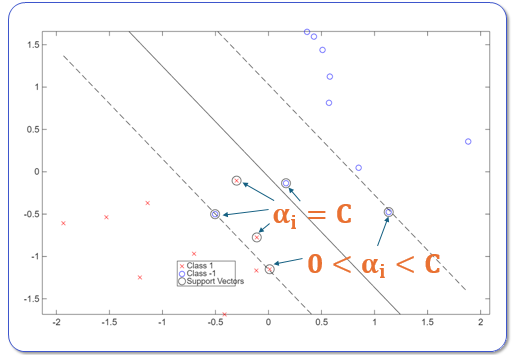

$\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$

$SVMP(Support\ Vectors\ on\ Magin\ Plane) = \{\mathbf{x}_i | 0 < \alpha_i < C\}$

임의의, $i \in SVMP$

$g_i(\mathbf{w}^*, b^*) = 0$

$0 = -y_i(\mathbf{w}^{*T}\mathbf{x}_i + b) + 1$

$b^* = y_i - (\boldsymbol{\alpha} \circ \mathbf{y})^T X \mathbf{x}_i$ $\Rightarrow$ $b^* = \frac{1}{N} \sum_{i \in SV} (y_i - (\boldsymbol{\alpha} \circ \mathbf{y})^T X \mathbf{x}_i)$

**[Ex.2]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_toy를 선형커널을 사용하여 Support Vector를 구해봅니다. Support Vector를 이용하여 Weight Vector를 구해봅니다.
    
</div>

In [7]:
from sklearn.svm import SVC
C = 1e5 # 선형 분리가 가능한 경우이므로 임의의 큰 수를 주었고, 최대한 분리해봅니다. 

clf_svc = SVC(C=C, kernel='linear')
clf_svc.fit(df_toy[['x1', 'x2']], df_toy['Class'])

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [8]:
clf_svc.support_vectors_, clf_svc.support_ # Support Vector와 Support Vector Index입니다.

(array([[2.5, 1. ],
        [2. , 2. ],
        [1. , 1. ]]),
 array([9, 2, 4]))

In [9]:
clf_svc.dual_coef_ # alpha × y 에 해당하는 값입니다.

array([[-1.7772,  1.3329,  0.4443]])

In [10]:
w = np.dot(clf_svc.dual_coef_, clf_svc.support_vectors_)
b = clf_svc.intercept_
w, b

(array([[-1.3329,  1.3329]]), array([0.99978333]))

선형 커널을 사용한 SVM의 Weight vector와 intercept_ 만으도 예측이 가능합니다. sklearn에서는 선형 커널을 사용하는 SVC를 따로 만들어 제공합니다.

In [11]:
from sklearn.svm import LinearSVC
clf_lsvc = LinearSVC(C=C)
clf_lsvc.fit(df_toy[['x1', 'x2']], df_toy['Class'])

LinearSVC(C=100000.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [12]:
clf_lsvc.coef_, clf_lsvc.intercept_

(array([[-1.3333278,  1.3332472]]), array([1.00006838]))

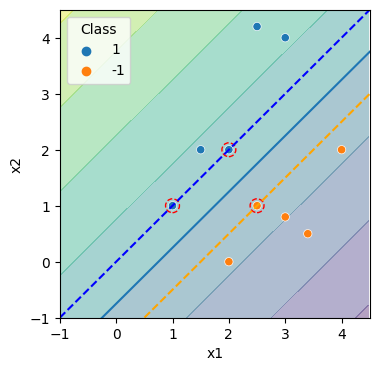

In [13]:
plt.figure(figsize=(4, 4))
plt.gca().set_xlim(-1, 4.5)
plt.gca().set_ylim(-1, 4.5)

xx, yy = np.meshgrid(np.arange(-1, 4.5, 0.02),
                     np.arange(-1, 4.5, 0.02))

# 각 점에 대한 예측값 계산
Z = clf_svc.decision_function(np.c_[xx.ravel(), yy.ravel()])

# 예측 결과를 시각화
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
x1_range = np.array([-1, 4.5])

plt.plot(x1_range, 1 * x1_range - 0.75)
plt.plot(x1_range, 1 * x1_range - 0.75 + 0.75, linestyle='dashed', color='blue')
plt.plot(x1_range, 1 * x1_range - 0.75 - 0.75, linestyle='dashed', color='orange')
plt.scatter(clf_svc.support_vectors_[:, 0], clf_svc.support_vectors_[:, 1], 
            s=100, color='r', facecolors='none', label='Support vectors',  linestyle='--')

plt.show()

### 4. 커널 트릭(Kernel Trick)

- 커널(Kernel): 하나의 데이터 포인트가 다른 데이터 포인트와의 관계성을 정량화하는 함수

$\chi \in R^n$

$K: \chi \times \chi \to R$

커널행렬(Kernel Matrix)

$\mathbf{x}_i = \begin{bmatrix} x_{i1} \\ x_{i2} \\ ... \\ x_{in} \end{bmatrix}$ $X = \begin{bmatrix} x_{11} & \cdots & x_{1n} \\ \vdots & \ddots & \vdots \\ x_{a1} & \cdots & x_{an} \end{bmatrix}$ $X = \begin{bmatrix} \mathbf{x}_1^T \\ \mathbf{x}_2^T \\ ... \\ \mathbf{x}_a^T \end{bmatrix}$

$\mathbf{y}_i = \begin{bmatrix} y_{i1} \\ y_{i2} \\ ... \\ y_{in} \end{bmatrix}$ $Y = \begin{bmatrix} y_{11} & \cdots & y_{1n} \\ \vdots & \ddots & \vdots \\ y_{b1} & \cdots & y_{bn} \end{bmatrix}$ $Y = \begin{bmatrix} \mathbf{y}_1^T \\ \mathbf{y}_2^T \\ ... \\ \mathbf{y}_b^T \end{bmatrix}$

주어진데이터X와Y의커널행렬은

$K(X, Y) = \begin{bmatrix} K(\mathbf{x}_1, \mathbf{y}_1) & \cdots & K(\mathbf{x}_1, \mathbf{y}_b) \\ K(\mathbf{x}_2, \mathbf{y}_1) & \cdots & K(\mathbf{x}_2, \mathbf{y}_b) \\ \vdots & \ddots & \vdots \\ K(\mathbf{x}_a, \mathbf{y}_1) & \cdots & K(\mathbf{x}_a, \mathbf{y}_b) \end{bmatrix}$



- 선형 커널

$\underset{\boldsymbol{\alpha}}{maximize} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T XX^T (\boldsymbol{\alpha} \circ \mathbf{y})$

$XX^T = \begin{bmatrix} \langle x_{11}, x_{11} \rangle & \cdots & \langle x_{11}, x_{m1} \rangle \\ \vdots & \ddots & \vdots \\ \langle x_{m1}, x_{11} \rangle & \cdots & \langle x_{mn}, x_{nm} \rangle \end{bmatrix}$

$XX^T$은 $K$가 두 벡터의 내적인 커널 행렬(Kernel Matrix)

$\chi \in R^n$ $K: \langle \mathbf{x}, \mathbf{y} \rangle$

- 선형 판별기가 Feature Mapping 을 통해 부적합한 데이터를 적합한 형태로 변환

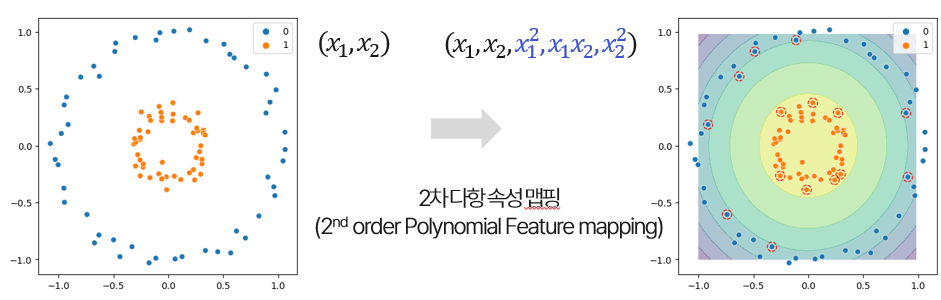

- 변수의 수와 차수가 커질수록 맵핑된 공간의 차원은 급격히 커짐 

#### 커널 트릭(Kernel Trick): 고차원의 속성을 만들지 않고도 고차원 속성의 효과를 유도

$(x_1, x_2)$ $\Rightarrow$ $(x_1, x_2, x_1^2, x_1 x_2, x_2^2)$

2차다항 속성 맵핑
(2nd Order Polynomial Feature Mapping)

$\langle (a_1, a_2, ..., a_n), (b_1, b_2, ..., b_n) \rangle^2$

$= (a_1 b_1 + a_2 b_2 + \cdots + a_n b_n)^2$

$= a_1^2 b_1^2 + 2a_1 b_1 a_2 b_2 + \cdots + a_2^2 b_2^2 + \cdots a_n^2 b_n^2$

$= \langle (a_1^2, \sqrt{2}a_1 a_2, ..., a_n^2), (b_1^2, \sqrt{2}b_1 b_2, ..., b_n^2) \rangle$

$\Rightarrow$ $K: \langle \mathbf{x}, \mathbf{y} \rangle^2$

#### 커널의 요건

- 대칭성

$𝐾(𝐱,𝐲)=𝐾(𝐲,𝐱)$

- 양의 준정성(Positive Semi-Definite)
> 임의의 입력 집합 ${𝐱_𝟏, …,𝐱_𝒏}$의 커널 행렬 K 에 대해
> 
> $\forall 𝐜 \in 𝑅_𝒏, \mathbf{𝐜}^𝑻\mathbf{𝐊}𝐜\ge𝟎$
> 
> $\Rightarrow$ 커널에 의해 유도되는 공간 내적이 성립함을 의미


#### 커널(Kernel)

|   | 커널 | 비고 |
| --- | --- | --- |
| 선형 커널<br/>(Linear Kernel) | $$\langle \mathbf{x}, \mathbf{y} \rangle$$ |   |
| 다항 커널<br/>(Polynomial Kernel) | $$(\gamma\langle \mathbf{x}, \mathbf{y} \rangle + b)^d$$  | 가 클수록 보다 복잡한 가설공간이 만들어짐<br/>$$b > 0$$: 비동차 다항 커널<br/>$$b = 0$$: 동차 다항 커널 |
| 방사 기저 함수 커널<br/>(Radial Base Function) | $$exp(-\gamma ||\mathbf{x}-\mathbf{y}||^2)$$  | 가 클수록 보다 복잡한 가설공간 이 만들어짐 |
| 시그모이드 커널<br/>(Sigmoid Kernel) | $$tanh(\gamma\langle \mathbf{x}, \mathbf{y} \rangle + b)$$  | 𝛾가 클수록 보다 복잡한 가설공간이 만들어짐 |



**[Ex_3]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

아래 코드는 원형의 결정 경계면을 갖는 데이터를 만듭니다. Linear Kernel과 2차 동차 다항 커널의 분류결과를 비교해봅니다.

비교는 accuracy로 합니다.

```python
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X_circle, y_circle = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=123)
```
    
</div>

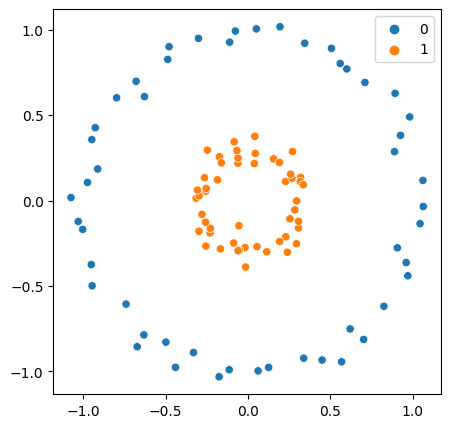

In [14]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X_circle, y_circle = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=123)

plt.figure(figsize=(5, 5))
sns.scatterplot(x = X_circle[:, 0], y=X_circle[:, 1], hue=y_circle)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

clf_lsvm = LinearSVC(C=1)
clf_lsvm.fit(X_circle, y_circle)
accuracy_score(y_circle, clf_lsvm.predict(X_circle))

0.5

In [16]:
from sklearn.metrics import accuracy_score

clf_svm = SVC(C=1, kernel='poly', degree=2, coef0=0, gamma=1)
clf_svm.fit(X_circle, y_circle)
accuracy_score(y_circle, clf_svm.predict(X_circle))

1.0

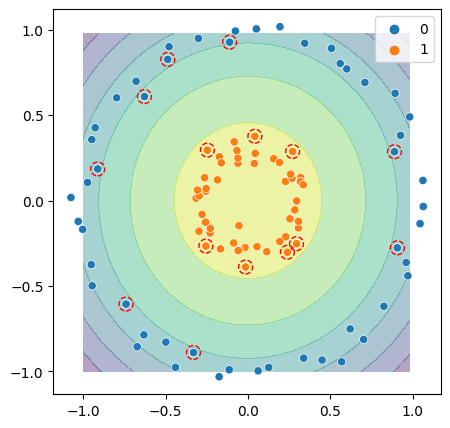

In [17]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X_circle, y_circle = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=123)

plt.figure(figsize=(5, 5))

xx, yy = np.meshgrid(np.arange(-1, 1, 0.02),
                     np.arange(-1, 1, 0.02))

# 각 점에 대한 예측값 계산
Z = clf_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])

# 예측 결과를 시각화
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

sns.scatterplot(x = X_circle[:, 0], y=X_circle[:, 1], hue=y_circle)

plt.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1], 
            s=100, color='r', facecolors='none', label='Support vectors',  linestyle='--')
plt.show()

### 5. Support Vector Machine

#### 최대 마진 분류 + 커널(Kernel)

$\underset{\boldsymbol{\alpha}}{maximize} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T X X^T (\boldsymbol{\alpha} \circ \mathbf{y})$

$\Rightarrow$ $\underset{\boldsymbol{\alpha}}{maximize} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} (\boldsymbol{\alpha} \circ \mathbf{y})^T K(X, X) (\boldsymbol{\alpha} \circ \mathbf{y})$

$\mathbf{w}^* = X^T(\boldsymbol{\alpha} \circ \mathbf{y})$

$SVMP(Support\ Vectors\ on\ Magin\ Plane) = \{\mathbf{x}_i | 0 < \alpha_i < C\}$

$b^* = \frac{1}{N} \sum_{i \in SVMP} (y_i - (\boldsymbol{\alpha} \circ \mathbf{y})^T K(X, \mathbf{x}_i))$

$f(\mathbf{x}) = (\boldsymbol{\alpha} \circ \mathbf{y})^T K(X, \mathbf{x}) + b^*$

선형커널일 경우,

$f(\mathbf{x}) = \mathbf{w}^{*T} \mathbf{x} + b^*$

**[Ex.4]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_gene를 train이 True 면 df_gene_train, False면 df_gene_test로 나눕니다.

df_gene_train에서 cancer(target)으로 입력 변수 별로 t-독립성 검정을 합니다(이분산을 가정합니다). 
    
검정 통계량의 절대값이 큰 변수를 우선적으로 1~200개 선택합니다. 선택한 개수별로 로지스틱 회귀분석과 Linear SVM의 성능을 비교해봅니다.

성능 비교는 df_gene_train으로 학습을 시키고 df_gene_test로 평가를 하여 평가셋에서의 성능을 봅니다. 

성능 지표: 정확도(Accuracy)
    
</div>

In [18]:
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

X_all = [i for i in df_gene.columns if i != 'cancer' and i != 'train']

def get_corr(X, y):
    scores, pvalues = list(), list() 
    # 입력 변수 X의 각 변수들의 대상 변수의 값이 AML, ALL로 구분했을 때의 t 검정을 수행합니다. 이 때 등분산이 아니라고 설정합니다.
    stat, pval  = ttest_ind(X[y == 'AML'], X[y == 'ALL'], equal_var=False)
    return np.abs(stat), pval

stat, pval = get_corr(df_gene[X_all], df_gene['cancer'])

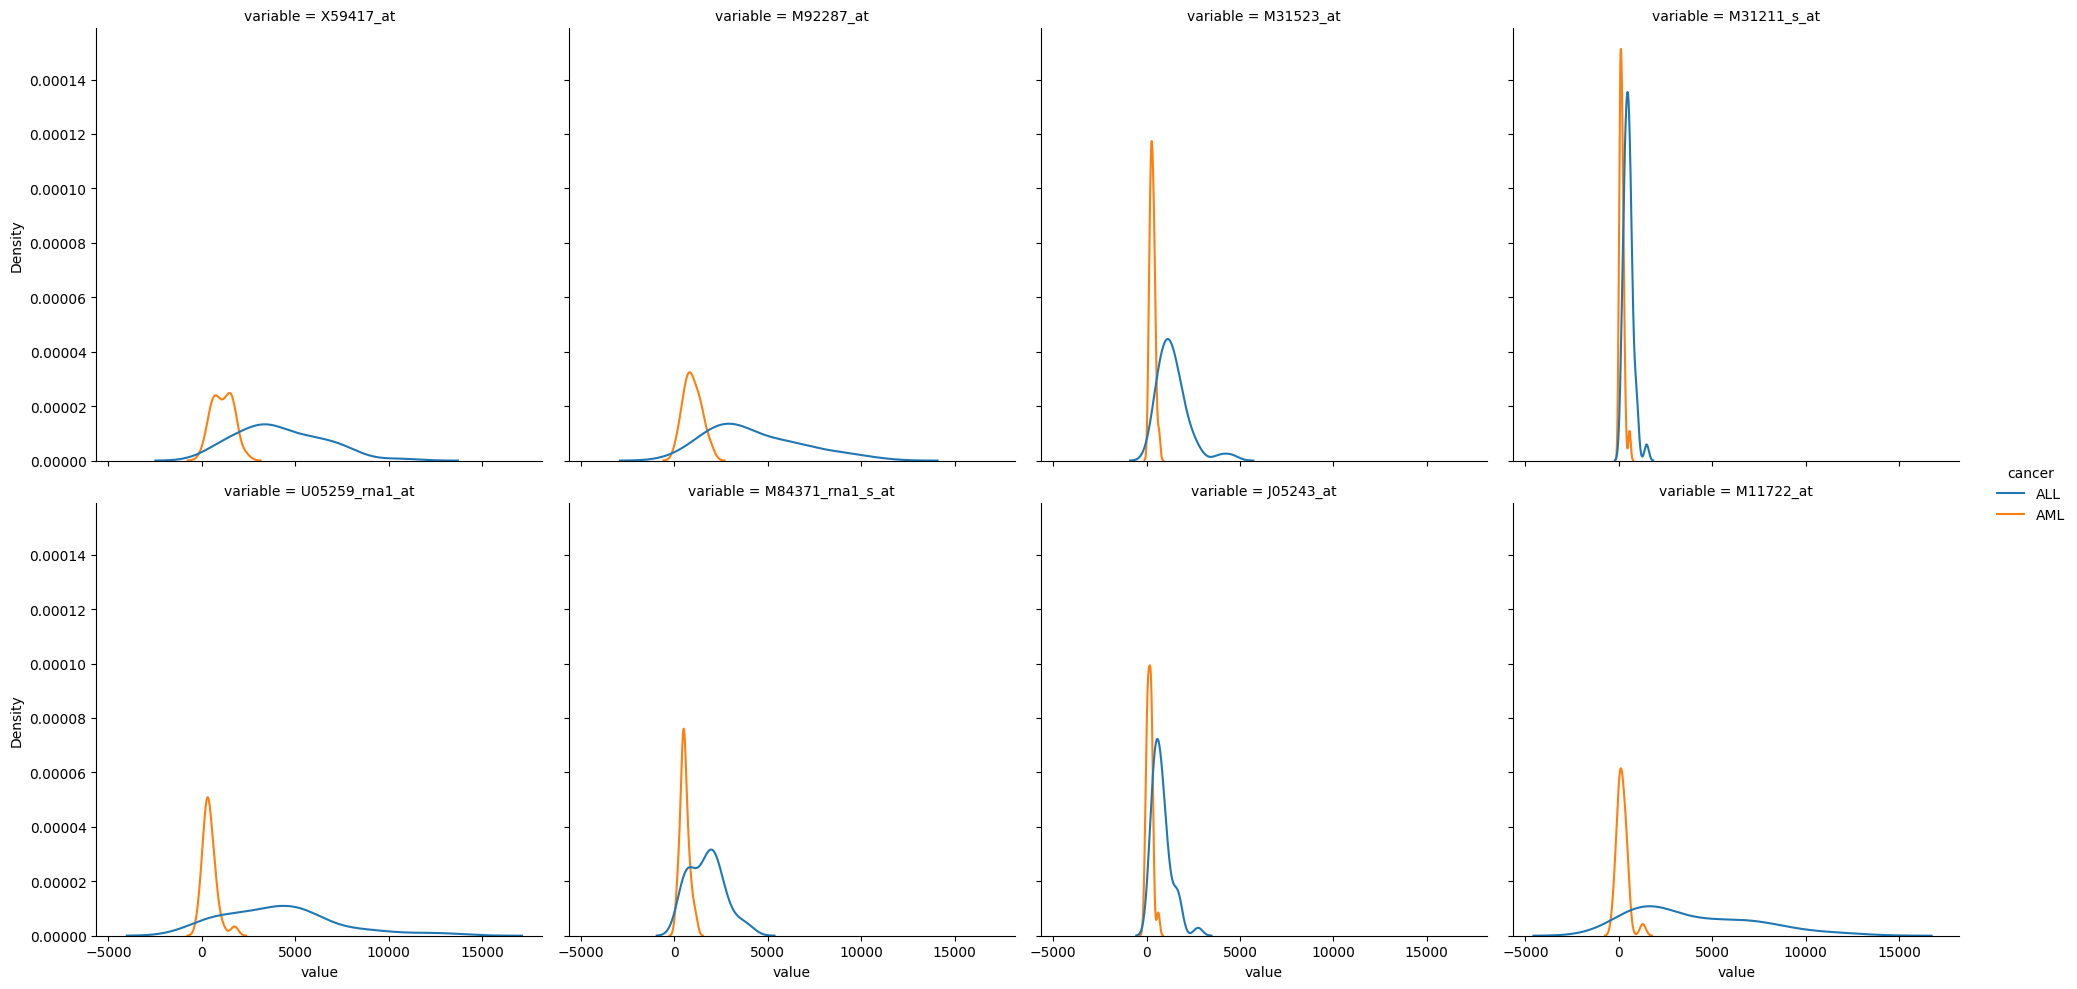

In [19]:
# t-독립성 검정의 pvalue 절대값를 기준으로 상위 8개의 변수들의 분포를 Kernel Density 차트로 시각화합니다.
sns.displot(
    data=pd.concat([df_gene.iloc[:, np.argsort(pval)[:8]], df_gene['cancer']], axis=1).melt(id_vars='cancer'), 
    x='value', col='variable', col_wrap=4, hue='cancer', kind='kde'
)
plt.show()

#### 다중 클래스 분류
- 단일 SVM 은 이진 분류만 가능
- 여러 SVM 을 통해 다중 클래스 문제에 대응
> One-Vs-Rest(OVR)
> 
> One-Vs- One(OVO)


#### 장단점

| 장점 | 단점 |
| --- | --- |
| 차원이 높은 데이터에서 효과적인 과적합 대응<br/>이론적 기반 견고 | 대용량 데이터에 부적합<br/>하이퍼 파라미터 튜닝 필요<br/>설명력이 떨어짐<br/>다중 클래스 문제에서 효율성이 떨어지는 OVR, OVO 방식 필수 |